# ぴよログデータ分析

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import os

In [2]:
# 誕生日
birth_date = datetime.datetime(2020, 1, 1)

## データ読込

In [3]:
# データ読込
path = './data'
files = os.listdir(path)
month_texts = []
for filename in files:
    f = open(f'{path}/{filename}', encoding='utf_8')
    data = f.read()
    month_texts.append(data)
    f.close()

In [4]:
# 対象項目
def check_item(text):
    if re.findall('起きる|寝る|母乳|ミルク|離乳食|搾母乳', text) and re.match(r'([01][0-9]|2[0-3]):[0-5][0-9]', text):
        return True
    return False

In [5]:
# 対象データをリスト化
def get_piyolog_all_items(month_texts):
    all_items = []

    for month_text in month_texts:
        # 改行で分割
        lines = month_text.splitlines()
        array = np.array(lines)

        for index, item in enumerate(array):
            # 日付取得
            if item == '----------' and index < len(array) - 1:
                day = array[index + 1][:-3]
                day_date = datetime.datetime.strptime(day, '%Y/%m/%d')

            # 対象項目の場合
            if item != '' and check_item(item):
                # 空白で分割
                record = item.split()

                record_dt = datetime.datetime.strptime(day + ' ' + record[0], '%Y/%m/%d %H:%M')
                record_type = None
                record_subtype = record[1]
                record_value = None
                record_timespan = None

                if '寝る' in record_subtype:
                    record_type = '睡眠'

                if '起きる' in record_subtype:
                    record_type = '睡眠'

                if 'ミルク' in record_subtype or '搾母乳' in record_subtype:
                    record_type = '食事'
                    # 搾母乳も項目名はミルクにする
                    record_subtype = 'ミルク'
                    # 時間は10分固定にする
                    record_timespan = 10
                    # ミルク量
                    record_value = int(record[2].replace('ml', ''))

                if '母乳' in record_subtype:
                    record_type = '食事'
                    record_time = 0
                    # 授乳時間の合計を計算する
                    for r in record[2:]:
                        if '分' in r:
                            record_time += int(r.replace('分',''))
                    record_timespan = record_time
                            
                # 記録
                all_items.append([day_date, record_dt, record_type, record_subtype, record_timespan, record_value])

    return all_items

In [6]:
df = pd.DataFrame(get_piyolog_all_items(month_texts),columns=['日付', '日時','分類','項目','時間','ミルク量'])

In [7]:
df.head()

,日付,日時,分類,項目,時間,ミルク量
0,2020-01-02,2020-01-02 01:00:00,食事,ミルク,10.0,30.0
1,2020-01-02,2020-01-02 05:00:00,食事,ミルク,10.0,30.0
2,2020-01-02,2020-01-02 07:00:00,睡眠,寝る,NaN,NaN
3,2020-01-02,2020-01-02 07:30:00,睡眠,起きる,NaN,NaN
4,2020-01-02,2020-01-02 07:35:00,食事,母乳,10.0,NaN


## データ加工

In [8]:
# 睡眠時間
s_sleep_timespan = df.query('分類=="睡眠"').sort_values('日時', ascending=False).日時.diff() * -1
s_sleep_timespan.name = '睡眠時間'
df = pd.concat([df, s_sleep_timespan], axis=1)

In [9]:
# 睡眠時間(timedelta)を分に直す
def sleeptime_to_minutes(x):
    return x.睡眠時間.seconds / 60
df["睡眠時間"] = df.apply(lambda x:sleeptime_to_minutes(x),axis=1)

In [10]:
# 時間帯
def replace_time_zone(x):
    # 7:00～19:00の間に寝たものは昼寝とする
    if x.日時.hour >= 7 and x.日時.hour <= 18:
        return '昼'
    else:
        return '夜'
        
df['時間帯'] = df.apply(lambda x:replace_time_zone(x),axis=1)

In [11]:
# 月齢
month_old_list = []
for i in range(0,10):
    month_old_list.append([birth_date + relativedelta(months=i+1),i])
    
def replace_month_old(x):
    for month_old in month_old_list:
        if x.日付 < month_old[0]:
            return month_old[1]
        
df['月齢'] = df.apply(lambda x:replace_month_old(x),axis=1)

In [12]:
df.head()

,日付,日時,分類,項目,時間,ミルク量,睡眠時間,時間帯,月齢
0,2020-01-02,2020-01-02 01:00:00,食事,ミルク,10.0,30.0,NaN,夜,0
1,2020-01-02,2020-01-02 05:00:00,食事,ミルク,10.0,30.0,NaN,夜,0
2,2020-01-02,2020-01-02 07:00:00,睡眠,寝る,NaN,NaN,30.0,昼,0
3,2020-01-02,2020-01-02 07:30:00,睡眠,起きる,NaN,NaN,430.0,昼,0
4,2020-01-02,2020-01-02 07:35:00,食事,母乳,10.0,NaN,NaN,昼,0


## 1日単位の集計

In [13]:
# 1日の夜に起きている回数・時間
df_night_wakeup = df.query('項目=="起きる" and 時間帯=="夜"').groupby('日付').agg({'日時':'count', '睡眠時間':'sum'}).reset_index()
df_night_wakeup.columns = ['日付','夜に起きる回数','夜に起きている時間']

In [14]:
# 1日の昼寝回数
df_nap = df.query('項目=="寝る" and 時間帯=="昼"').groupby('日付').agg({'日時':'count', '睡眠時間':'sum'}).reset_index()
df_nap.columns = ['日付','昼寝回数', '昼寝時間']

In [15]:
# 1日の食事回数
df_milk = df.query('項目=="ミルク"').groupby('日付').agg({'日時':'count', 'ミルク量':'sum'}).reset_index()
df_milk.columns = ['日付','ミルク回数', 'ミルク量']
df_mother_milk = df.query('項目=="母乳"').groupby('日付').agg({'日時':'count', '時間':'sum'}).reset_index()
df_mother_milk.columns = ['日付','授乳回数', '授乳時間']
df_eat = df.query('項目=="離乳食"').groupby('日付').agg({'日時':'count', '時間':'sum'}).reset_index()
df_eat.columns = ['日付','離乳食回数', '離乳食時間']

In [16]:
# 1日集計のdf結合
df_groupby_day = pd.merge(df_nap, df_night_wakeup, on='日付', how='left')
df_groupby_day = pd.merge(df_groupby_day, df_milk, on='日付', how='left')
df_groupby_day = pd.merge(df_groupby_day, df_mother_milk, on='日付', how='left')
df_groupby_day = pd.merge(df_groupby_day, df_eat, on='日付', how='left')

In [17]:
# 月齢列の追加
df_groupby_day['月齢'] = df_groupby_day.apply(lambda x:replace_month_old(x),axis=1)

In [18]:
df_groupby_day.head()

,日付,昼寝回数,昼寝時間,夜に起きる回数,夜に起きている時間,ミルク回数,ミルク量,授乳回数,授乳時間,離乳食回数,離乳食時間,月齢
0,2020-01-02,3,230.0,3,90.0,10.0,290.0,5,46.0,NaN,NaN,0
1,2020-01-03,3,445.0,4,195.0,10.0,430.0,7,63.0,NaN,NaN,0
2,2020-01-04,3,220.0,5,295.0,10.0,470.0,8,142.0,NaN,NaN,0
3,2020-01-05,3,375.0,5,205.0,7.0,290.0,11,186.0,NaN,NaN,0
4,2020-01-06,4,395.0,7,330.0,5.0,190.0,15,243.0,NaN,NaN,0


## 月齢別の集計

In [19]:
# 夜寝の1回あたりの睡眠時間
df_night_sleep_per_event = df.query('項目=="寝る" and 時間帯=="夜"').groupby('月齢').agg({'睡眠時間':['mean','std']})
# 昼寝の1回あたりの睡眠時間
df_nap_per_event = df.query('項目=="寝る" and 時間帯=="昼"').groupby('月齢').agg({'睡眠時間':['mean','std']})
# 授乳の1回あたりの時間
df_mother_milk_per_event = df.query('項目=="母乳"').groupby('月齢').agg({'時間':['mean','std']})
# ミルクの1回あたりの量
df_milk_per_event = df.query('項目=="ミルク"').groupby('月齢').agg({'ミルク量':['mean','std']})


In [20]:
df_night_sleep_per_event.columns = pd.MultiIndex.from_arrays([['1回あたりの夜寝時間','1回あたりの夜寝時間'],['mean','std']])
df_nap_per_event.columns = pd.MultiIndex.from_arrays([['1回あたりの昼寝時間','1回あたりの昼寝時間'],['mean','std']])
df_mother_milk_per_event.columns = pd.MultiIndex.from_arrays([['1回あたりの授乳時間','1回あたりの授乳時間'],['mean','std']])
df_milk_per_event.columns = pd.MultiIndex.from_arrays([['1回あたりのミルク量','1回あたりのミルク量'],['mean','std']])

In [21]:
# 1日集計のデータを月齢別に集計
df_groupby_month = df_groupby_day.groupby('月齢').agg({'昼寝回数':['mean','std'], '昼寝時間':['mean','std'], '夜に起きる回数':['mean','std'], '夜に起きている時間':['mean','std'], 'ミルク回数':['mean','std'], 'ミルク量':['mean','std'], '授乳回数':['mean','std'], '授乳時間':['mean','std'], '離乳食回数':['mean','std']})

In [22]:
df_groupby_month = pd.merge(df_groupby_month, df_night_sleep_per_event, on='月齢', how='left')
df_groupby_month = pd.merge(df_groupby_month, df_nap_per_event, on='月齢', how='left')
df_groupby_month = pd.merge(df_groupby_month, df_mother_milk_per_event, on='月齢', how='left')
df_groupby_month = pd.merge(df_groupby_month, df_milk_per_event, on='月齢', how='left')

In [23]:
pd.options.display.precision = 1
df_groupby_month.head()

昼寝回数        昼寝時間       夜に起きる回数      夜に起きている時間        ミルク回数       ... 離乳食回数  \
   mean  std   mean   std    mean  std      mean    std  mean  std  ...  mean   
月齢                                                                  ...         
0   4.6  1.1  351.4  78.0     4.6  1.4     301.0   95.1   5.9  2.4  ...   NaN   
1   6.4  1.7  329.3  86.8     5.5  1.7     274.7  101.6   5.2  0.9  ...   NaN   
2   4.5  1.1  299.4  77.3     2.9  1.1     195.8   97.9   2.8  0.9  ...   NaN   
3   4.3  1.1  272.0  87.3     2.8  0.9     173.7   75.1   2.5  0.7  ...   NaN   
4   3.6  1.1  227.1  51.5     2.7  1.0     126.6   78.2   2.1  0.4  ...   NaN   

       1回あたりの夜寝時間        1回あたりの昼寝時間       1回あたりの授乳時間      1回あたりのミルク量        
   std       mean    std       mean   std       mean  std       mean   std  
月齢                                                                          
0  NaN       85.5   50.2       76.0  41.0       10.5  6.0       60.3  23.1  
1  NaN       77.6   54.3       51.7  37.4        9.4  4.4      111.0  22.7  
2  NaN      147.6  108.2       65.8  39.9        9.8  3.9      140.0  24.2  
3  NaN      159.9  142.0       62.8  37.6        7.9  3.9      133.6  30.6  
4  NaN      184.8  132.9       62.9  37.3        8.4  3.8      144.8  27.0  

[5 rows x 26 columns]

## 可視化

In [24]:
pd.plotting.register_matplotlib_converters()
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [25]:
# 夜に起きる回数とお昼寝回数の月齢推移
df_graph_night_wakeup_count = df_groupby_month['夜に起きる回数']['mean']
df_graph_nap_count = df_groupby_month['昼寝回数']['mean']
df_graph_night_wakeup_nap_count = pd.concat([df_graph_night_wakeup_count, df_graph_nap_count], axis=1)
df_graph_night_wakeup_nap_count.columns = ['夜に起きる回数','昼寝回数']

In [26]:
# 1回あたりの睡眠時間平均の月齢推移
df_graph_night_sleep_time_per_event = df_groupby_month['1回あたりの夜寝時間']['mean'] / 60
df_graph_nap_time_per_event = df_groupby_month['1回あたりの昼寝時間']['mean'] / 60
df_graph_night_sleep_nap_time_per_event = pd.concat([df_graph_night_sleep_time_per_event, df_graph_nap_time_per_event], axis=1)
df_graph_night_sleep_nap_time_per_event.columns = ['1回あたりの夜寝時間','1回あたりの昼寝時間']

In [27]:
# 起きている時間/昼寝の月齢推移
df_graph_night_wakeup_time = df_groupby_month['夜に起きている時間']['mean'] / 60
df_graph_nap_time = df_groupby_month['昼寝時間']['mean'] / 60
df_graph_night_wakeup_nap_time = pd.concat([df_graph_night_wakeup_time, df_graph_nap_time], axis=1)
df_graph_night_wakeup_nap_time.columns = ['夜に起きている時間','昼寝時間']

In [28]:
# 食事回数の月齢推移
df_graph_milk = df_groupby_month['ミルク回数']['mean']
df_graph_mother_milk = df_groupby_month['授乳回数']['mean']
df_graph_eat = df_groupby_month['離乳食回数']['mean']
df_graph_eat_count = pd.concat([df_graph_milk, df_graph_mother_milk], axis=1)
df_graph_eat_count = pd.concat([df_graph_eat_count, df_graph_eat], axis=1)
df_graph_eat_count.columns = ['ミルク','授乳','離乳食']

In [29]:
# 1回あたりの授乳時間平均の月齢推移
df_graph_mother_milk_per_event = df_groupby_month['1回あたりの授乳時間']['mean']
# 1回あたりのミルク量平均の月齢推移
df_graph_milk_ml_per_event = df_groupby_month['1回あたりのミルク量']['mean']

In [30]:
# ミルク量/授乳時間の月齢推移
df_graph_milk_ml = df_groupby_month['ミルク量']['mean']
df_graph_mother_milk_time = df_groupby_month['授乳時間']['mean'] / 60

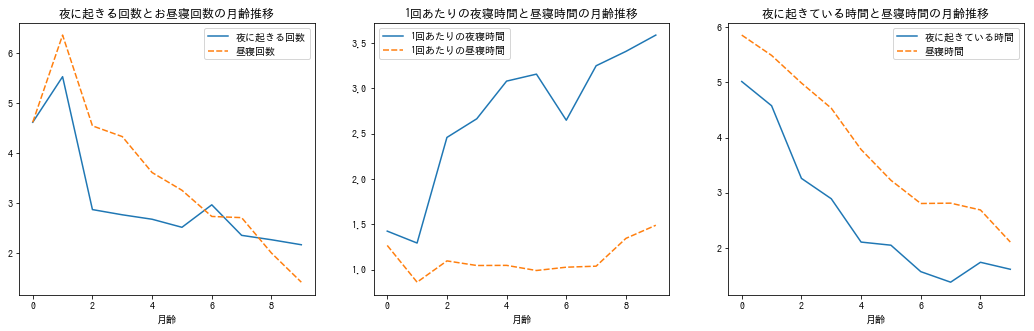

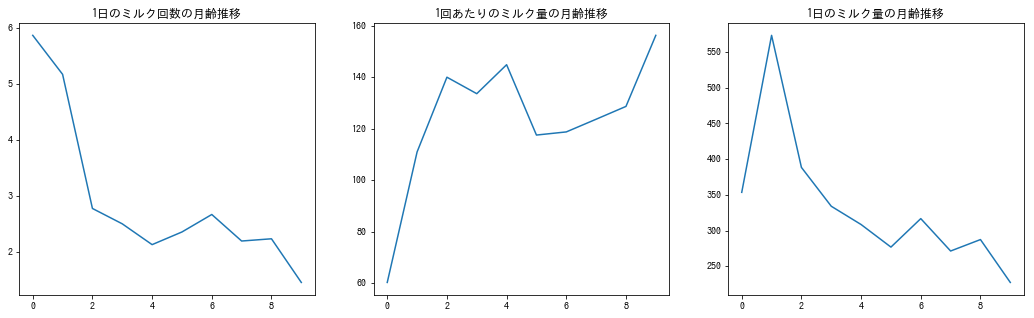

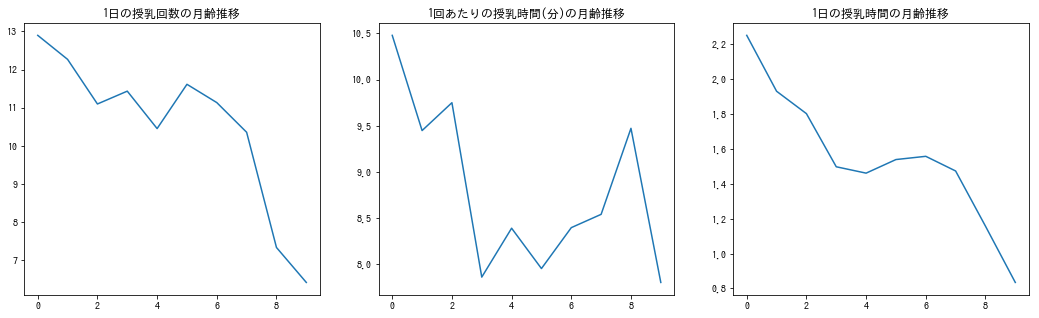

In [31]:
fig1,(ax1, ax2, ax3)=plt.subplots(1,3,figsize=(18,5))
ax1.set_title('夜に起きる回数とお昼寝回数の月齢推移')
sns.lineplot(data=df_graph_night_wakeup_nap_count, ax=ax1)
ax2.set_title('1回あたりの夜寝時間と昼寝時間の月齢推移')
sns.lineplot(data=df_graph_night_sleep_nap_time_per_event, ax=ax2)
ax3.set_title('夜に起きている時間と昼寝時間の月齢推移')
sns.lineplot(data=df_graph_night_wakeup_nap_time, ax=ax3)

fig2,(ax4, ax5, ax6)=plt.subplots(1,3,figsize=(18,5))
ax4.set_title('1日のミルク回数の月齢推移')
sns.lineplot(data=df_graph_milk, ax=ax4)
ax5.set_title('1回あたりのミルク量の月齢推移')
sns.lineplot(data=df_graph_milk_ml_per_event, ax=ax5)
ax6.set_title('1日のミルク量の月齢推移')
sns.lineplot(data=df_graph_milk_ml, ax=ax6)

fig3,(ax7,ax8,ax9)=plt.subplots(1,3,figsize=(18,5))
ax7.set_title('1日の授乳回数の月齢推移')
sns.lineplot(data=df_graph_mother_milk, ax=ax7)
ax8.set_title('1回あたりの授乳時間(分)の月齢推移')
sns.lineplot(data=df_graph_mother_milk_per_event, ax=ax8)
ax9.set_title('1日の授乳時間の月齢推移')
sns.lineplot(data=df_graph_mother_milk_time, ax=ax9)

■新生児期(0～1ヶ月)の特徴

夜に起きる回数が多く、1回あたりの夜寝時間が短く、夜に起きている時間トータルも長い。  
→夜間に何度も授乳(ミルク)が必要で親がまとまった睡眠がとれないため、夜はとても大変。

一方で昼寝回数も多く、1回あたりの昼寝時間は短い。昼寝時間トータルは長いため、起きている時間は短い。  
→昼寝時間トータルは長いが1回あたりの時間は短いため、睡眠不足で昼寝したくてもまとまって寝れないので体力的につらい。  
起きている時間は短くベビーベッドで寝ているだけなので、ある程度目は離せる。

食事の回数は多く、1回あたりのミルクの量は少ない。母乳の出が少ないため授乳時間は1回あたり・1日トータルともに長い。  
→ほぼ一日中ミルクと授乳をしていて、体力的にもつらい。

夜のつらさ　★★★★★★★  
昼のつらさ　☆★★★★

■ねんね期(2～4ヶ月)の特徴

夜に起きる回数がやや減り、1回あたりの夜寝時間すこし長くなり、夜に起きている時間トータルもやや短くなる。  
→新生児期よりはましだが、まだまだ夜間授乳が必要で睡眠不足が続く。

昼寝回数はまだ多く、1回あたりの昼寝時間は短い。昼寝時間トータルは長いため、起きている時間は短い。  
→睡眠不足だが多少は体力的にましになる。  
起きている時間は短くベビーベッドで寝ているだけなので、引き続きある程度目は離せる。

ミルクの回数はかなり減り、1回あたりのミルク量がかなり増える。授乳時間は1回あたり・1日トータルともに短くなる。  
→1回に飲める量が多くなるため、食事回数が減ってやや楽になる。  

夜のつらさ　☆★★★★  
昼のつらさ　☆☆☆★★

■寝返り・おすわり期(5～7ヶ月)

夜に起きる回数が減り、1回あたりの夜寝時間が長くなり、夜に起きている時間トータルも短くなる。  
→夜間授乳が減って親がある程度まとまった睡眠がとれるようになるため、夜はやや楽になる。

昼寝回数は減るが、1回あたりの昼寝時間はあまり変わらない。昼寝時間トータルは短くなり、起きている時間が長くなる。  
→睡眠不足が解消されるため、昼寝時間を自由時間として使えるようになる。  
起きている時間は長くなりあやす必要があるが、移動しないで勝手に遊んでくれるので多少は目が離せる。  
昼にリングフィットをやったりしていたので、結構余裕があった気がする。

1回あたりのミルク量がやや減り、1日トータルの量が減る。授乳はあまり変わらない。  
→離乳食がはじまるため、ミルク・授乳が減る。離乳食は準備と食べさせることに時間がかかるため、少し大変になる。  

夜のつらさ　☆☆★★★  
昼のつらさ　☆☆☆☆★

■はいはい期(8～10ヶ月)

夜に起きる回数がさらに減り、1回あたりの夜寝時間がさらに長くなり、夜に起きている時間トータルもさらに短くなる。  
→夜間授乳がかなり減り親がまとまった睡眠がとれるようになるため、夜はかなり楽になる。

昼寝回数はさらに減り、1回あたりの昼寝時間が長くなる。昼寝時間トータルは短くなり、起きている時間が長くなる。  
→昼寝時間が長くなるため、ある程度まとまった自由時間ができる。  
起きている時間はかなり長くなりあやす必要があり、はいはいで移動するので目が離せなくなってくる。  
子守にテレビが必須になってくる。Eテレが神になる。

ミルク・授乳の回数はさらに減る。  
→離乳食の回数が増えるため、ミルク・授乳ともにさらに減る。離乳食の回数が増えるとそこそこ忙しくなる。

夜のつらさ　☆☆☆☆★  
昼のつらさ　☆☆☆★★
